In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl as opx
import scipy.optimize as scy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

2023-11-11 13:06:26.089806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 13:06:26.130890: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 13:06:26.131786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 13:06:26.845902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=pd.read_excel(r'anonymizedData.xlsx','P_Tracao')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### Achar quantidade de na por coluna

In [3]:
v=[]
for col in df.columns:
    v.append(df[col].isna().sum())

### Filtrar as colunas que possuam 700 ou menos termos Nan


In [4]:
v=pd.DataFrame(v).reset_index()
w=v[v[0]<700]['index']

In [5]:
df=df.iloc[:,w]

### Filtrar as colunas que possuam estabilidade menor que 400 termos na coluna


In [6]:
r=[]
for col in df.columns:
    r.append(len(df[col].value_counts()))
r=pd.DataFrame(r).reset_index()
w=r[(r[0]>400)]
w=w._append(r.iloc[-1]).index

In [7]:
df=df.iloc[:,w]


### Retirar as linhas que tem muitos Nan

In [8]:
S = df.drop('P_Tracao',axis=1)
r=[]
for index in df.index:
    r.append(len(S.loc[index,:].value_counts()))

In [9]:
r=pd.DataFrame(r).reset_index()
w=r[(r[0]>0.75*len(df.columns))]

df=df.iloc[w['index'],:]


### Preencher Nan com zeros

In [10]:
df=df.interpolate()

df=df.fillna(0)

### Criação de matriz de correlação

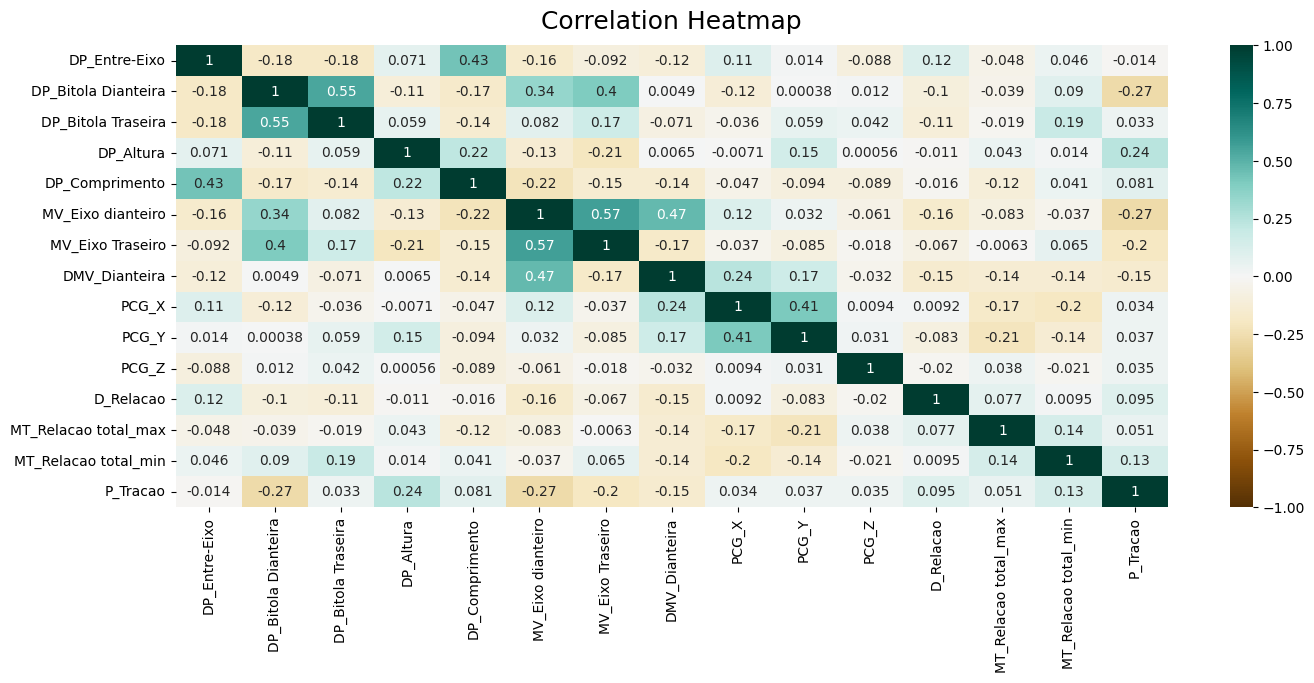

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped


### Eliminando colunas com mais de 30% de correlação

In [12]:
# Create correlation matrix
corr = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

In [13]:
df.corr()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Altura,DP_Comprimento,MV_Eixo dianteiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,D_Relacao,MT_Relacao total_max,MT_Relacao total_min,P_Tracao
DP_Entre-Eixo,1.000000,-0.183995,0.071041,0.430686,-0.159658,-0.115254,0.105057,0.014492,-0.087690,0.115462,-0.048401,0.045716,-0.013585
DP_Bitola Dianteira,-0.183995,1.000000,-0.112348,-0.167625,0.340962,0.004853,-0.121046,0.000384,0.011605,-0.101329,-0.039246,0.090168,-0.269991
DP_Altura,0.071041,-0.112348,1.000000,0.218857,-0.134552,0.006494,-0.007114,0.153659,0.000558,-0.011349,0.042834,0.013602,0.240891
DP_Comprimento,0.430686,-0.167625,0.218857,1.000000,-0.220799,-0.142759,-0.047010,-0.093569,-0.089348,-0.015794,-0.115280,0.041415,0.080938
MV_Eixo dianteiro,-0.159658,0.340962,-0.134552,-0.220799,1.000000,0.471776,0.116529,0.032422,-0.060868,-0.158191,-0.082796,-0.036933,-0.272267
DMV_Dianteira,-0.115254,0.004853,0.006494,-0.142759,0.471776,1.000000,0.242028,0.165459,-0.032357,-0.152783,-0.139919,-0.139530,-0.152138
PCG_X,0.105057,-0.121046,-0.007114,-0.047010,0.116529,0.242028,1.000000,0.411378,0.009390,0.009186,-0.172956,-0.196536,0.033811
PCG_Y,0.014492,0.000384,0.153659,-0.093569,0.032422,0.165459,0.411378,1.000000,0.030738,-0.083463,-0.211716,-0.138858,0.037435
PCG_Z,-0.087690,0.011605,0.000558,-0.089348,-0.060868,-0.032357,0.009390,0.030738,1.000000,-0.019662,0.038045,-0.021220,0.035097
D_Relacao,0.115462,-0.101329,-0.011349,-0.015794,-0.158191,-0.152783,0.009186,-0.083463,-0.019662,1.000000,0.076766,0.009508,0.094957


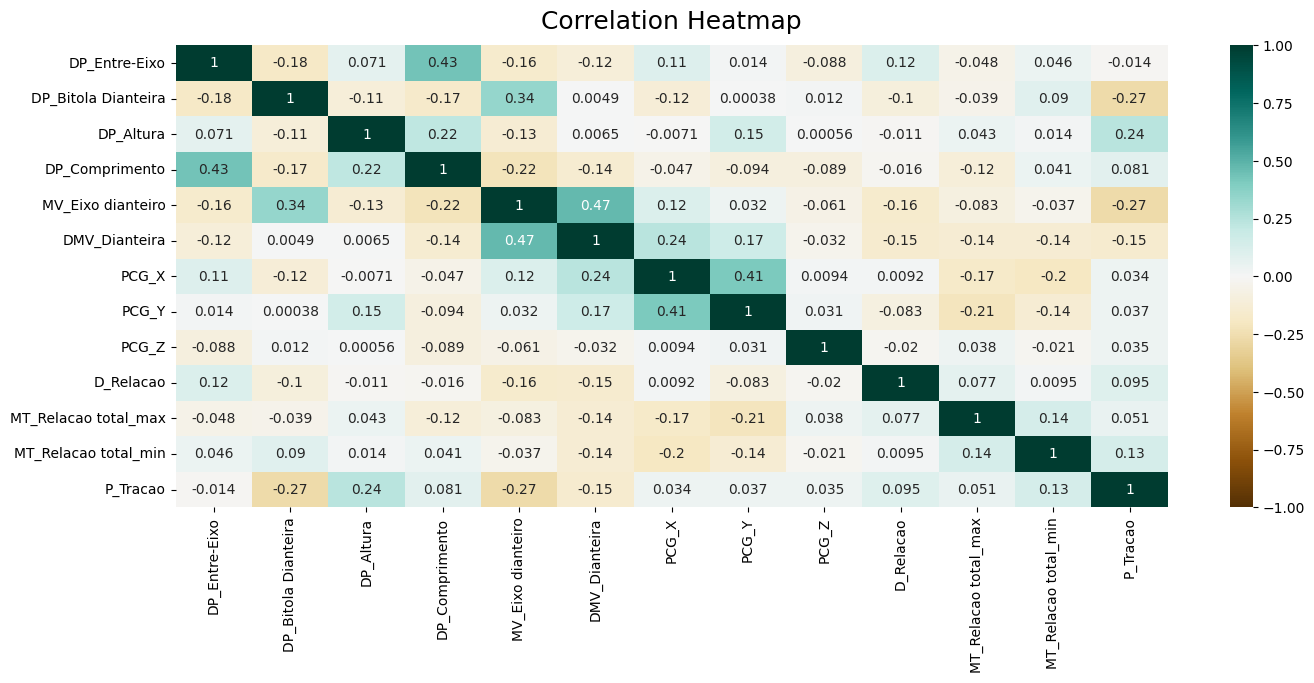

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped

In [15]:
#sns.pairplot(df,hue='P_Tracao')

### Modelo de regressão logística

In [16]:
X = df.drop(['P_Tracao'],axis=1)
y = df['P_Tracao']

In [17]:
X.shape[1]

12

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

In [19]:
logistic_regression= LogisticRegression(solver='liblinear',max_iter=100000)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

<Axes: xlabel='Predicted', ylabel='Actual'>

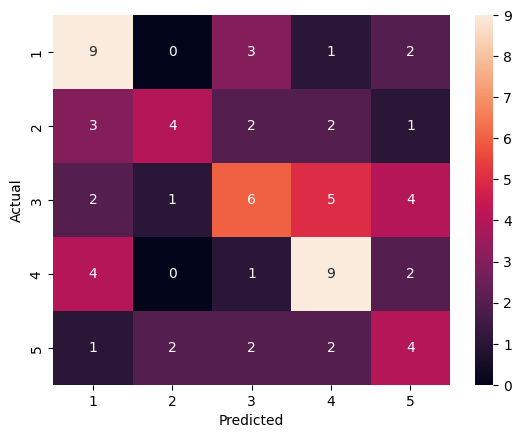

In [20]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [21]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy:  0.4444444444444444


### Modelo usando reder neural KERAS


In [92]:
# Ajustar os rótulos para começar de 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Número de classes
num_classes = 5

# Criar o modelo de regressão logística multiclasse com o Keras
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))  # Camada oculta 1
model.add(Dense(32, activation='relu'))  # Camada oculta 2
model.add(Dense(num_classes, input_dim=7, activation='softmax'))


# Compilar o modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train_adjusted, epochs=50, batch_size=32, validation_split=0.4)


# Fazer previsões no conjunto de teste
y_pred = np.argmax(model.predict(X_test), axis=1) + 1 

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

Epoch 1/50


KeyboardInterrupt: 

### loop aumentando o número de camadas


In [ ]:
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


np.random.seed(1)

# Função para construir o modelo com um número variável de camadas
def build_model(num_layers, num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons[0], input_dim=X.shape[1], activation='relu'))

    for i in range(1, num_layers):
        model.add(Dense(num_neurons[i], activation='relu'))

    model.add(Dense(5, activation='softmax'))
#Adam(learning_rate=0.0001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.0001), metrics=['accuracy'])
    return model


# Loop para escolher o número de camadas
for num_layers in range(11,13):  # Pode ajustar o intervalo conforme necessário
    # Loop para escolher o número de neurônios em cada camada
    for num_neurons in range(504, 506, 2):  # Pode ajustar o intervalo conforme necessário
        # Construir o modelo
        model = build_model(num_layers, [num_neurons] * num_layers)

        # Treinar o modelo
        model.fit(X_train, y_train - 1, epochs=400, batch_size=200, validation_split=0.01,verbose=0)  # Ajustar rótulos

        # Fazer previsões no conjunto de teste
        y_pred = np.argmax(model.predict(X_test), axis=1) + 1  # Adicionar 1 para reverter o ajuste

        # Avaliar a precisão do modelo
        accuracy = accuracy_score(y_test, y_pred)

        # Imprimir informações sobre o modelo
        print(f"Número de camadas: {num_layers}, Neurônios por camada: {num_neurons}, Acurácia: {accuracy}")




7/7 [==============================] - 0s 4ms/step
Número de camadas: 11, Neurônios por camada: 504, Acurácia: 0.5545023696682464
7/7 [==============================] - 0s 3ms/step
Número de camadas: 12, Neurônios por camada: 504, Acurácia: 0.5071090047393365


### Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#Aplique K-Means clustering
num_clusters = 5  # pois você tem 5 classes
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train)

# Obtenha rótulos de cluster para os dados de treinamento
y_train_clusters = kmeans.predict(X_train)

# Obtenha rótulos de cluster para os dados de teste
y_test_clusters = kmeans.predict(X_test)

# Avalie a precisão do clustering usando a correspondência de rótulos com as classes reais
accuracy_train = accuracy_score(y_train, y_train_clusters)
accuracy_test = accuracy_score(y_test, y_test_clusters)

print(f'Acurácia no conjunto de treinamento: {accuracy_train}')
print(f'Acurácia no conjunto de teste: {accuracy_test}')

Acurácia no conjunto de treinamento: 0.1690427698574338
Acurácia no conjunto de teste: 0.17061611374407584


/home/eduardo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### GMM metodo

In [ ]:

from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar GMM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Número de clusters (n_components) deve ser o número de classes
n_components = 5

# Crie o modelo GMM
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Treine o modelo no conjunto de treinamento
gmm.fit(X_train_scaled)

# Obtenha rótulos de cluster para os dados de treinamento e teste
y_train_pred = gmm.predict(X_train_scaled)
y_test_pred = gmm.predict(X_test_scaled)

# Avalie a precisão do clustering usando a correspondência de rótulos com as classes reais
accuracy_train = accuracy_score(y_train, y_train_pred + 1)  # Adiciona 1 para reverter o ajuste
accuracy_test = accuracy_score(y_test, y_test_pred + 1)  # Adiciona 1 para reverter o ajuste

print(f'Acurácia no conjunto de treinamento: {accuracy_train}')
print(f'Acurácia no conjunto de teste: {accuracy_test}')


Acurácia no conjunto de treinamento: 0.24439918533604887
Acurácia no conjunto de teste: 0.27014218009478674


### Randon Forest

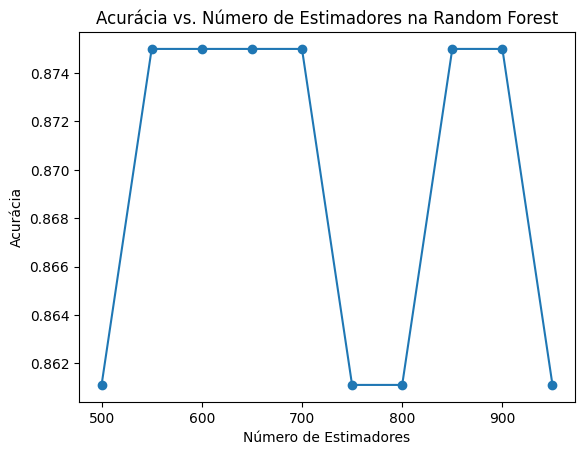

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Padronize os dados (é uma prática comum ao usar Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Varie o número de estimadores
num_estimators_range = range(500,1000,50)
accuracy_scores = []

for num_estimators in num_estimators_range:
    # Crie o modelo de Random Forest com o número atual de estimadores
    model = RandomForestClassifier(n_estimators=num_estimators, random_state=42,max_depth=2000,criterion='entropy')

    # Treine o modelo no conjunto de treinamento
    model.fit(X_train_scaled, y_train)

    # Faça previsões no conjunto de teste
    y_pred = model.predict(X_test_scaled)

    # Avalie a precisão do modelo e armazene
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)




# Plote a relação entre o número de estimadores e a acurácia
plt.plot(num_estimators_range, accuracy_scores, marker='o')
plt.title('Acurácia vs. Número de Estimadores na Random Forest')
plt.xlabel('Número de Estimadores')
plt.ylabel('Acurácia')
plt.show()



In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler


# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Padronize os dados (é uma prática comum ao usar Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crie o modelo Random Forest
model = RandomForestClassifier(n_estimators=800, random_state=42,max_depth=2000,criterion='entropy')

# Realize a validação cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=20)  # cv é o número de dobras na validação cruzada

# Imprima os scores de validação cruzada
print("Scores de Validação Cruzada:", cv_scores)
print("Acurácia Média: {:.2f}%".format(np.mean(cv_scores) * 100))

/home/eduardo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 97 members, which is less than n_splits=100.
  warnings.warn(


Scores de Validação Cruzada: [1.         0.85714286 0.85714286 0.85714286 0.71428571 0.71428571
 1.         0.71428571 0.57142857 1.         0.71428571 0.85714286
 0.71428571 0.85714286 0.57142857 1.         0.71428571 1.
 0.85714286 1.         0.71428571 1.         1.         0.57142857
 0.71428571 0.85714286 1.         0.85714286 0.57142857 1.
 1.         0.85714286 0.85714286 1.         0.71428571 0.85714286
 0.85714286 1.         1.         0.85714286 0.83333333 0.83333333
 1.         1.         0.66666667 0.83333333 1.         1.
 0.83333333 0.83333333 0.83333333 0.83333333 1.         0.83333333
 0.83333333 0.66666667 1.         0.83333333 1.         1.
 0.66666667 0.66666667 1.         1.         0.83333333 0.83333333
 1.         1.         0.83333333 0.5        0.83333333 0.66666667
 0.66666667 0.66666667 1.         0.5        0.5        1.
 0.66666667 0.66666667 0.83333333 1.         0.66666667 0.83333333
 0.83333333 0.5        0.83333333 0.83333333 0.66666667 0.83333333
 0.666

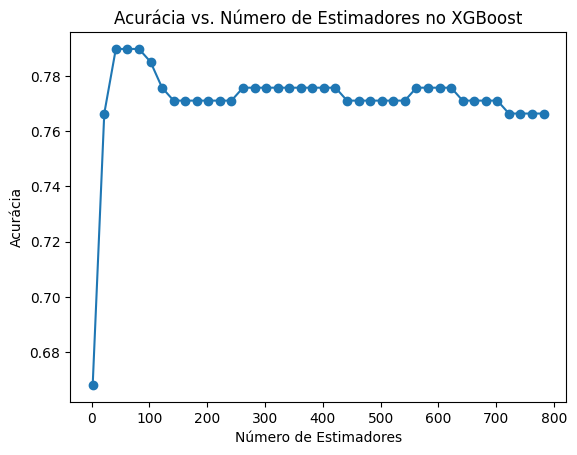

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y-1, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar XGBoost)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Varie o número de estimadores
num_estimators_range = range(2,800,20)
accuracy_scores = []

for num_estimators in num_estimators_range:
    # Crie o modelo XGBoost com o número atual de estimadores
    model = XGBClassifier(n_estimators=num_estimators, random_state=42)

    # Treine o modelo no conjunto de treinamento
    model.fit(X_train_scaled, y_train)

    # Faça previsões no conjunto de teste
    y_pred = model.predict(X_test_scaled)

    # Avalie a precisão do modelo e armazene
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plote a relação entre o número de estimadores e a acurácia
plt.plot(num_estimators_range, accuracy_scores, marker='o')
plt.title('Acurácia vs. Número de Estimadores no XGBoost')
plt.xlabel('Número de Estimadores')
plt.ylabel('Acurácia')
plt.show()


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y-1, test_size=0.3, random_state=101)

# Padronize os dados (é uma prática comum ao usar KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crie o modelo KNN
model = KNeighborsClassifier(n_neighbors=1)  # você pode ajustar o número de vizinhos (k) conforme necessário

# Treine o modelo no conjunto de treinamento
model.fit(X_train_scaled, y_train)

# Faça previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# Avalie a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)

print(f'Acurácia do KNN: {accuracy}')

Acurácia do KNN: 0.7663551401869159


### Otimização baysiana

In [33]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt.space import Real, Categorical, Integer


# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Padronize os dados (é uma prática comum ao usar otimização bayesiana)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defina os espaços de busca para os hiperparâmetros
param_space = {
    'n_estimators': Integer(500, 700),
    'max_depth': Integer(900, 1000),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion' : Categorical(['entropy','gini'])
}

# Crie o modelo de Random Forest
rf_model = RandomForestClassifier()

# Inicialize a busca bayesiana
opt = BayesSearchCV(
    rf_model,
    param_space,
    n_iter=50,  # Número de iterações da busca
    n_jobs=-1,
    cv=5,  # Número de dobras na validação cruzada
    random_state=42,
)

# Execute a otimização
opt.fit(X_train_scaled, y_train)

# Imprima os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(opt.best_params_)

# Avalie o modelo otimizado
y_pred = opt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo otimizado: {accuracy}')


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Melhores Hiperparâmetros:
OrderedDict([('criterion', 'entropy'), ('max_depth', 970), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 516)])
Acurácia do modelo otimizado: 0.8461538461538461
